<a href="https://colab.research.google.com/github/NatureBase/EndTermTask/blob/main/EndTermTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fish Classification with ResNet-50

## Import Libraries

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

## Prepare Dataset

In [17]:
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive")
data_path = Path('/content/drive/My Drive/Fish_Dataset/Fish_Dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
def prepare_data(data_path):
    # Read filepaths and labels
    filepaths = list(data_path.glob(r'**/*.png'))
    labels = list(map(lambda x: x.parent.name, filepaths))

    # Create DataFrame
    data = pd.DataFrame({'filepath': filepaths, 'label': labels})

    # Filter data
    data = data[~data['label'].str.contains("GT", na=False)]
    sea_bass_df = data[data['label'] == 'Sea Bass']
    sea_bass_drop = sea_bass_df.index[:10]  # Get indices of the first 10 'Sea Bass' rows
    data = data.drop(index=sea_bass_drop)
    # Initialize a list to store indices of rows to drop
    rows_to_drop = []

    # Iterate over unique labels in the DataFrame
    for label in data['label'].unique():
        # Skip labels containing 'GT'
        if "GT" in label:
            continue
        # Get the indices of rows with the current label (limit to first 300)
        label_indices = data[data['label'] == label].index[:500]
        # Add these indices to the list of rows to drop
        rows_to_drop.extend(label_indices)

    # Drop the selected rows from the DataFrame
    data = data.drop(index=rows_to_drop)

    # Map labels to integers
    label_mapping = {label: idx for idx, label in enumerate(data['label'].unique())}
    data['label_idx'] = data['label'].map(label_mapping)

    # Split into train, validation, and test sets
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

    return train_df, val_df, test_df, label_mapping

In [19]:
# Prepare data
train_df, val_df, test_df, label_mapping = prepare_data(data_path)

## Data Augmentation and Transformation

In [21]:
# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Custom Dataset Class
# Custom Dataset Class
class FishDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['filepath']).convert('RGB')  # Open the image
        label = row['label']

        # Convert the label to an integer index if needed
        label = torch.tensor(label_mapping[label])  # Replace `label_mapping` with your mapping

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label  # Ensure both are tensors

# Datasets and DataLoaders
train_dataset = FishDataset(train_df, transform=train_transform)
val_dataset = FishDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Implementattion Without Fine-Tuning Strategy

### Train Data Without Fine-Tuning Strategy

In [22]:
# Load pretrained ResNet-50
resnet50 = models.resnet50(pretrained=True)

# Modify the final layer
num_classes = len(train_df['label'].unique())
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Placeholder lists to track training and validation losses
train_losses = []
val_losses = []

# Example: Add this tracking inside your training loop
for epoch in range(10):  # Number of epochs
    # Training phase
    resnet50.train()
    running_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    resnet50.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1, Train Loss: 0.4568, Validation Loss: 1.1715
Epoch 2, Train Loss: 0.1478, Validation Loss: 0.0915
Epoch 3, Train Loss: 0.0816, Validation Loss: 0.4890
Epoch 4, Train Loss: 0.1369, Validation Loss: 0.0849
Epoch 5, Train Loss: 0.0620, Validation Loss: 0.2721
Epoch 6, Train Loss: 0.0339, Validation Loss: 0.0014
Epoch 7, Train Loss: 0.0513, Validation Loss: 0.2713
Epoch 8, Train Loss: 0.0577, Validation Loss: 0.0356
Epoch 9, Train Loss: 0.0311, Validation Loss: 0.5981
Epoch 10, Train Loss: 0.0284, Validation Loss: 0.0349


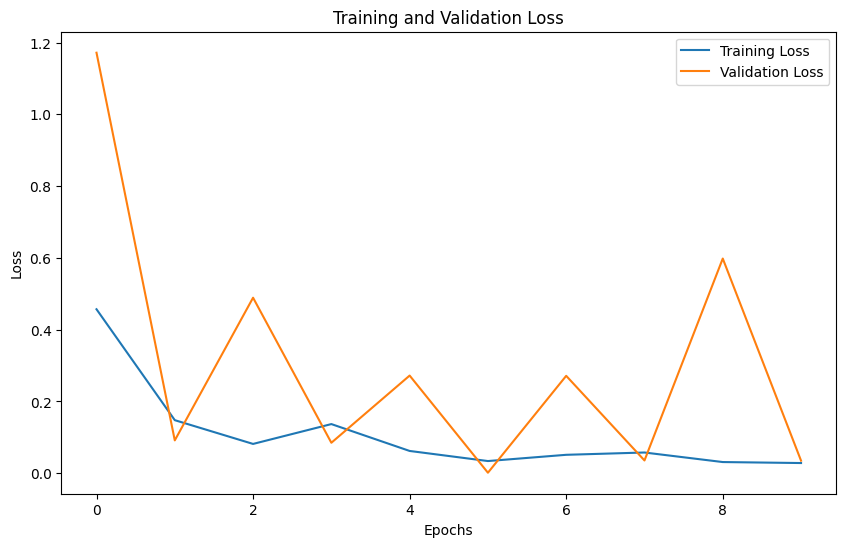

In [25]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Test Data Without Fine-Tuning Strategy

In [26]:
test_dataset = FishDataset(test_df, transform=train_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
# Step 7: Test the Model
def test_model(model, test_loader, device):

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            # Move data to the specified device
            images, labels = images.to(device), labels.to(device)

            # Get predictions from the model
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print accuracy
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Call the function
test_model(resnet50, test_loader, device)


Test Accuracy: 99.56%


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Classification Report:
                    precision    recall  f1-score   support

          Sea Bass       0.97      1.00      0.98        59
             Trout       1.00      1.00      1.00        54
   Hourse Mackerel       1.00      1.00      1.00        47
            Shrimp       1.00      1.00      1.00        40
   Gilt-Head Bream       1.00      1.00      1.00        44
     Red Sea Bream       1.00      1.00      1.00        52
Striped Red Mullet       1.00      1.00      1.00        43
        Red Mullet       1.00      1.00      1.00        52
   Black Sea Sprat       1.00      0.97      0.98        59

          accuracy                           1.00       450
         macro avg       1.00      1.00      1.00       450
      weighted avg       1.00      1.00      1.00       450



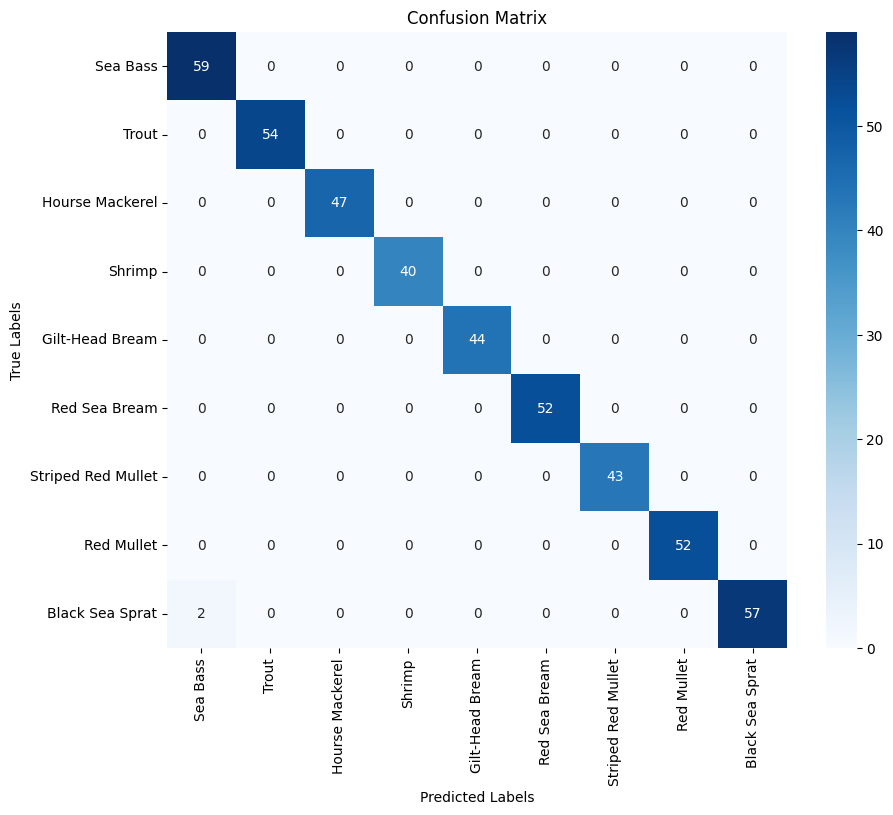

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, test_loader, device, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Reverse the label mapping
    reversed_label_mapping = {v: k for k, v in label_mapping.items()}
    target_names = [reversed_label_mapping[i] for i in range(len(reversed_label_mapping))]

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Call the evaluation function
evaluate_model(resnet50, test_loader, device, label_mapping)

## Implementattion With Fine-Tuning Strategy

## Train Data With Fine-Tuning Strategy

In [35]:
# Load ResNet-50 pretrained on ImageNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = models.resnet50(pretrained=True)

# Modify the fully connected layer for your number of classes
num_classes = len(train_df['label'].unique())
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50 = resnet50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# Freeze initial layers
for param in resnet50.parameters():
    param.requires_grad = False

# Unfreeze only the final layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

# Define loss and optimizer for training the top layers
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

# Training the top layers
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [37]:
for epoch in range(5):  # Initial training for the top layers
    resnet50.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    resnet50.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1, Train Loss: 0.8767, Train Acc: 0.8039, Val Loss: 0.3119, Val Acc: 0.9822
Epoch 2, Train Loss: 0.2551, Train Acc: 0.9639, Val Loss: 0.1650, Val Acc: 0.9889
Epoch 3, Train Loss: 0.1747, Train Acc: 0.9719, Val Loss: 0.1132, Val Acc: 0.9889
Epoch 4, Train Loss: 0.1206, Train Acc: 0.9808, Val Loss: 0.0903, Val Acc: 0.9844
Epoch 5, Train Loss: 0.1084, Train Acc: 0.9803, Val Loss: 0.0651, Val Acc: 0.9956


In [38]:
# Unfreeze all layers for fine-tuning
for param in resnet50.parameters():
    param.requires_grad = True

# Reduce learning rate for fine-tuning
optimizer = optim.Adam(resnet50.parameters(), lr=1e-5)

In [39]:
# Fine-tuning the entire model
for epoch in range(10):  # Fine-tuning phase
    resnet50.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    resnet50.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1, Train Loss: 0.0395, Train Acc: 0.9944, Val Loss: 0.0079, Val Acc: 1.0000
Epoch 2, Train Loss: 0.0104, Train Acc: 0.9992, Val Loss: 0.0034, Val Acc: 1.0000
Epoch 3, Train Loss: 0.0058, Train Acc: 0.9994, Val Loss: 0.0025, Val Acc: 1.0000
Epoch 4, Train Loss: 0.0039, Train Acc: 1.0000, Val Loss: 0.0011, Val Acc: 1.0000
Epoch 5, Train Loss: 0.0030, Train Acc: 0.9997, Val Loss: 0.0009, Val Acc: 1.0000
Epoch 6, Train Loss: 0.0027, Train Acc: 0.9994, Val Loss: 0.0006, Val Acc: 1.0000
Epoch 7, Train Loss: 0.0015, Train Acc: 0.9997, Val Loss: 0.0005, Val Acc: 1.0000
Epoch 8, Train Loss: 0.0011, Train Acc: 0.9997, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 9, Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.0003, Val Acc: 1.0000
Epoch 10, Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.0003, Val Acc: 1.0000


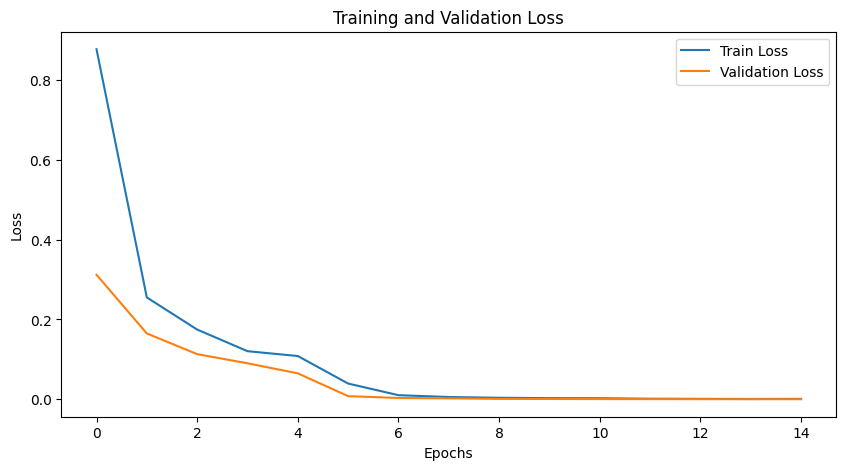

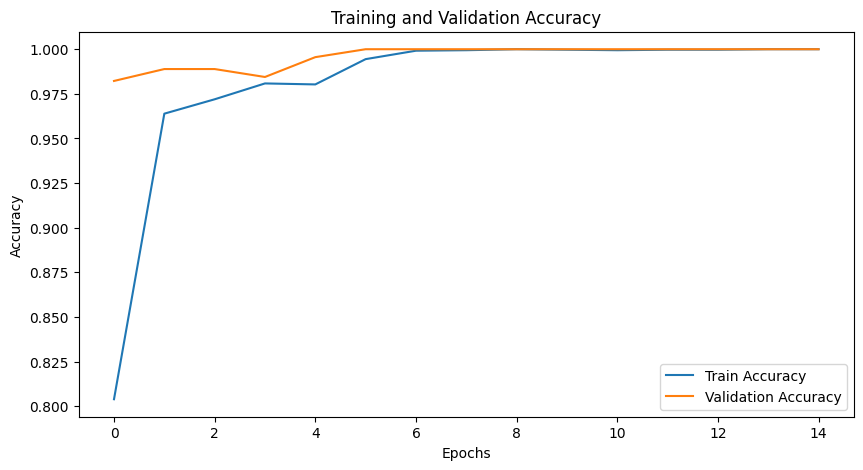

In [40]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Test Data With Fine-Tuning Strategy

In [41]:
# Test the Model
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

test_model(resnet50, test_loader, device)

Test Accuracy: 100.00%


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Classification Report:
                    precision    recall  f1-score   support

          Sea Bass       1.00      1.00      1.00        59
             Trout       1.00      1.00      1.00        54
   Hourse Mackerel       1.00      1.00      1.00        47
            Shrimp       1.00      1.00      1.00        40
   Gilt-Head Bream       1.00      1.00      1.00        44
     Red Sea Bream       1.00      1.00      1.00        52
Striped Red Mullet       1.00      1.00      1.00        43
        Red Mullet       1.00      1.00      1.00        52
   Black Sea Sprat       1.00      1.00      1.00        59

          accuracy                           1.00       450
         macro avg       1.00      1.00      1.00       450
      weighted avg       1.00      1.00      1.00       450



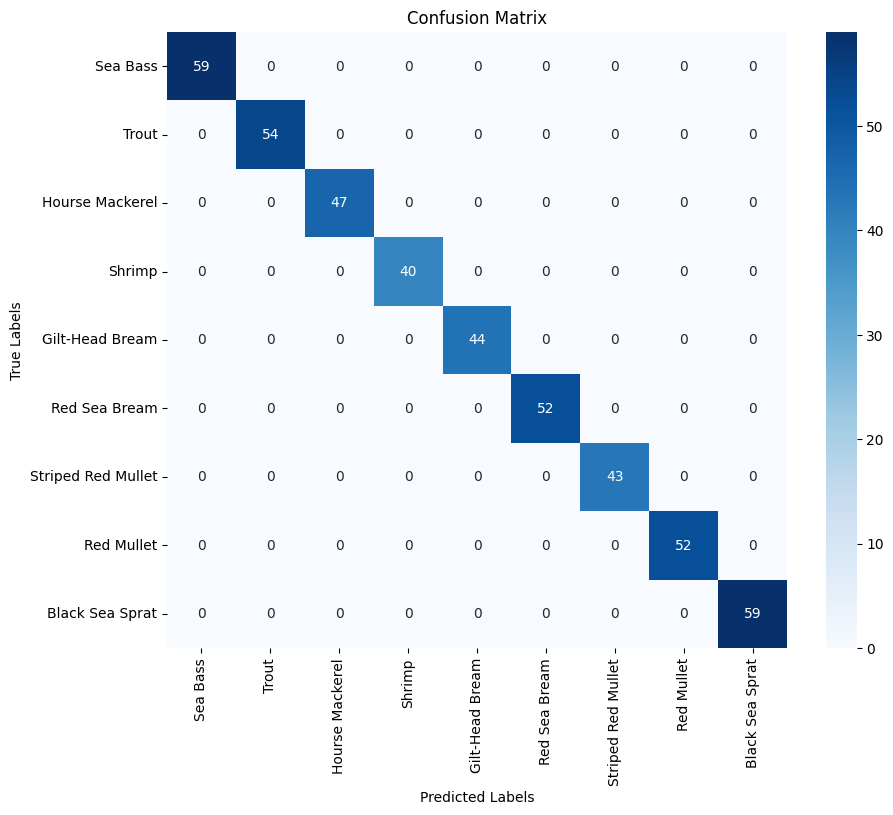

In [42]:
# Evaluate the Model
def evaluate_model(model, test_loader, device, label_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    reversed_label_mapping = {v: k for k, v in label_mapping.items()}
    target_names = [reversed_label_mapping[i] for i in range(len(reversed_label_mapping))]

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(resnet50, test_loader, device, label_mapping)